In [1]:
%matplotlib inline


# Transfer Learning for Computer Vision Tutorial
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

/home/plankton/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize((224,224)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,
        #0.456, 
        #0.406
        ], 
        [0.229, 
        #0.224, 
        #0.225
        ])
    ]),
    'val': transforms.Compose([
        #transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 
        #0.456, 
        #0.406
        ], [0.229, 
        #0.224, 
        #0.225
        ])
    ]),
}

data_dir = '/home/plankton/Data/labeled_plankton'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], 
    batch_size=1,
    shuffle=True, 
    num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#image_datasets['train']
x = next(iter(dataloaders['train']))[0]
x = torch.unsqueeze(x, dim=0)
x.shape

torch.Size([1, 1, 1, 46, 55])

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



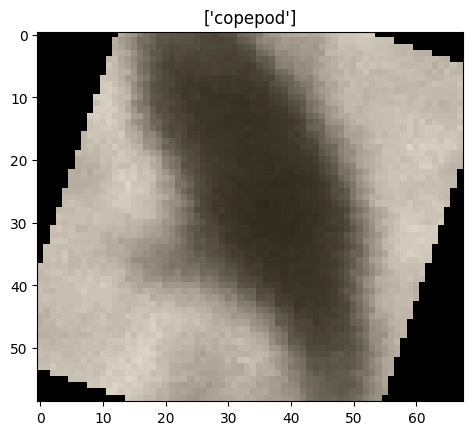

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [7]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    wts_dic = {}
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            #elif phase == 'val':
            #    wts_dic[epoch]= copy.deepcopy(model.state_dict())
            
            writer.add_scalar(f'{phase} Loss:', epoch_loss, epoch)
            writer.add_scalar(f'{phase} Accuracy:', epoch_acc, epoch)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [12]:

#defining a new resnet model with only 1 input channel instead of 3. Following: https://discuss.pytorch.org/t/modify-resnet-or-vgg-for-single-channel-grayscale/22762/9 
class resnet_1ch(models.resnet.ResNet):

    def __init__(self, block, layers, num_classes=2):
        self.inplanes = 64
        super(resnet_1ch, self).__init__(block, layers)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
# instantiate a resnet50 with bottleneck according to: https://github.com/pytorch/vision/blob/791c172a337d98012018f98ffde93b1020ba3ed5/torchvision/models/resnet.py#L236
model_ft = resnet_1ch(models.resnet.Bottleneck, [3, 4, 6, 3])

#print(model_ft)

In [13]:
#model_ft = models.resnet50(weights='ResNet50_Weights.DEFAULT')
#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
#model_ft = torch.load(save_dir)
#model_ft = model_ft.to(device)
#model_ft, wts_dict = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/24
----------
train Loss: 2.9147 Acc: 0.6785
val Loss: 8.8615 Acc: 0.4503

Epoch 1/24
----------
train Loss: 2.1697 Acc: 0.7081
val Loss: 17.7779 Acc: 0.4921

Epoch 2/24
----------
train Loss: 2.1032 Acc: 0.7519
val Loss: 4.5004 Acc: 0.4921

Epoch 3/24
----------
train Loss: 2.0878 Acc: 0.7584
val Loss: 6.9447 Acc: 0.5079

Epoch 4/24
----------
train Loss: 1.2920 Acc: 0.7777
val Loss: 15.6889 Acc: 0.4974

Epoch 5/24
----------


In [59]:
run_name = 'resnet50_copepod_1ch_sd.pth'
save_dir = os.path.join('/home/plankton/Data',run_name)
torch.save(model_ft.state_dict(), save_dir)

In [53]:
wts_dict

NameError: name 'wts_dic' is not defined

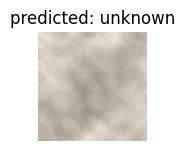

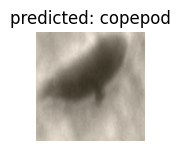

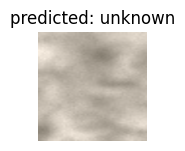

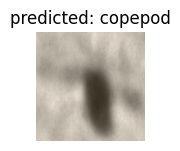

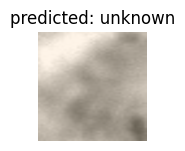

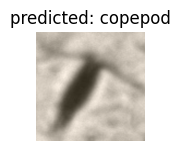

In [44]:
#model_ft=model_ft.to(device)
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [13]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4623 Acc: 0.7945
val Loss: 0.3317 Acc: 0.8691

Epoch 1/24
----------
train Loss: 0.4531 Acc: 0.8167
val Loss: 0.3120 Acc: 0.8848

Epoch 2/24
----------
train Loss: 0.4960 Acc: 0.8158
val Loss: 0.3714 Acc: 0.7958

Epoch 3/24
----------
train Loss: 0.5289 Acc: 0.8034
val Loss: 0.4609 Acc: 0.7330

Epoch 4/24
----------
train Loss: 0.4475 Acc: 0.8175
val Loss: 0.2644 Acc: 0.8953

Epoch 5/24
----------
train Loss: 0.4437 Acc: 0.8220
val Loss: 0.2869 Acc: 0.8848

Epoch 6/24
----------
train Loss: 0.5053 Acc: 0.8043
val Loss: 0.2818 Acc: 0.8953

Epoch 7/24
----------
train Loss: 0.3911 Acc: 0.8264
val Loss: 0.3326 Acc: 0.8429

Epoch 8/24
----------
train Loss: 0.3655 Acc: 0.8521
val Loss: 0.3340 Acc: 0.8534

Epoch 9/24
----------
train Loss: 0.3608 Acc: 0.8601
val Loss: 0.3056 Acc: 0.8901

Epoch 10/24
----------
train Loss: 0.3515 Acc: 0.8503
val Loss: 0.2794 Acc: 0.8848

Epoch 11/24
----------
train Loss: 0.3887 Acc: 0.8485
val Loss: 0.3033 Acc: 0.8743

Ep

In [ ]:
torch.save(model_conv.state_dict(), PATH)

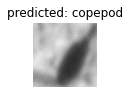

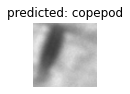

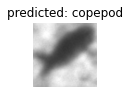

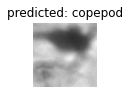

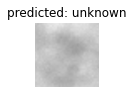

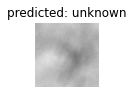

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).



